In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end], "-")
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
def trend(time, slope=0):
  return time*slope

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return seasonal_pattern(season_time) * amplitude

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.random(len(time)) * noise_level

In [ ]:
time = np.arange(4*365+1, dtype="float32")
baseline = 10

series = baseline + trend(time, slope=0.05) + seasonality(time, period=365, amplitude=40)
series += noise(time, noise_level=20, seed=42)

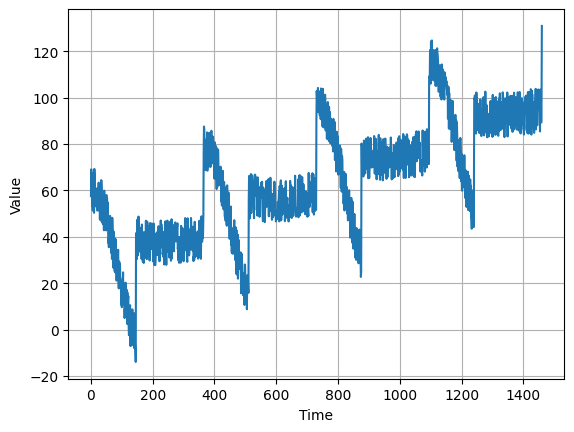

In [ ]:
plot_series(time, series)

In [ ]:
split_time = 1000
train_time = time[:split_time]
train_series = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  # dateset = dataset.map(lambda window: (window[:-1], window[-1]))
  # return dataset.shuffle(shuffle_buffer)
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  return dataset.batch(batch_size).prefetch(1)

In [ ]:
dataset = windowed_dataset(train_series, 20, 32, 1000)

In [ ]:
# for x, y in dataset:
#   print(x.numpy(), y.numpy())
#   break

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[20])
model = tf.keras.models.Sequential([l0])

model.compile(loss = "mse", optimizer = "adam")
# model.summary()
model.fit(dataset, epochs=100, verbose=0)

In [ ]:
print(l0.get_weights())

[array([[-0.02811738],
       [-0.01346046],
       [ 0.02648943],
       [-0.01286203],
       [-0.02407014],
       [ 0.06377326],
       [-0.02615569],
       [ 0.00298633],
       [ 0.01109319],
       [-0.08639491],
       [ 0.10054622],
       [-0.06073334],
       [ 0.00598173],
       [ 0.10620391],
       [ 0.04095468],
       [ 0.0861686 ],
       [ 0.09324248],
       [ 0.08763748],
       [ 0.19433075],
       [ 0.4314351 ]], dtype=float32), array([0.01554939], dtype=float32)]


In [ ]:
window_size = 20
forecast = []

In [ ]:
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

1/1 [==============================] - 0s 23ms/step


In [ ]:
forecast = forecast[split_time-window_size:]

In [ ]:
result = np.array(forecast)[:, 0, 0]

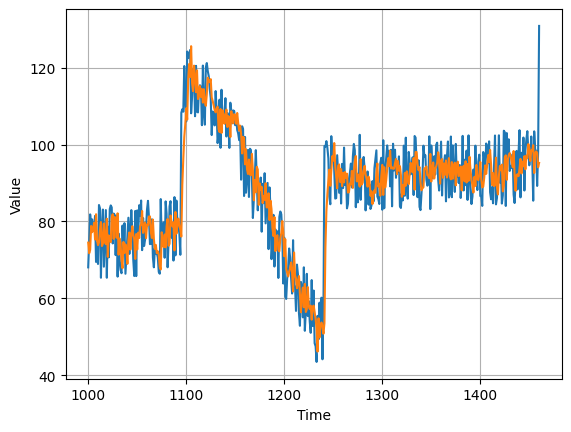

In [ ]:
plot_series(time_valid, series_valid)
plot_series(time_valid, result)

In [ ]:
tf.keras.metrics.mean_absolute_error(series_valid, result).numpy()

6.3374944